# Natural Language Processing with Disaster Tweets

The challenge problem is to look at some tweets and determine if the tweet is referencing an actual disaster (1) or not (0). For the training data each tweet has a `text` field with the text of the tweet, an optional `keyword` field that might have a focal keyword of the text, an optional `location` field of where the tweet was made from, and finally a binary field `target` of if the tweet referenced an actual distaster (1) or not (0). NLP (Natural Language Processing) of topic extraction will be used.

Datset citation: Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dense, Input, Dropout, LSTM, GRU, ConvLSTM2D, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pathlib import Path

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exploratory Data Analysis (EDA)

From the dataset description, I am leaning towards only using the `text` and `target` field from the input because the `keyword` and `location` are not always filled in.

In [2]:
# Load in the data
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

print("Test DataFrame info:")
print(test_df.info())
print("Train DataFrame info:")
print(train_df.info())

Test DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
Train DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [3]:
# Dropping fields of no interest
test_df.drop(axis=1, inplace=True, labels=["keyword", "location"])
train_df.drop(axis=1, inplace=True, labels=["keyword", "location"])


# Check for any empty text fields that may need to be handled

# Check count for null fields, which doesn't check for empty strings
print("Null Field Counts:")
print(test_df.isnull().sum())
print(train_df.isnull().sum())

print("-" * 6)

# Check count for empty 
print("Empty Field Counts:")
print(test_df.eq("").sum())
print(train_df.eq("").sum())

Null Field Counts:
id      0
text    0
dtype: int64
id        0
text      0
target    0
dtype: int64
------
Empty Field Counts:
id      0
text    0
dtype: int64
id        0
text      0
target    0
dtype: int64


No empty fields to account for. Now looking at the text field lengths.

Test:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: text, dtype: float64
Train:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text, dtype: float64
Unique Words:
36826


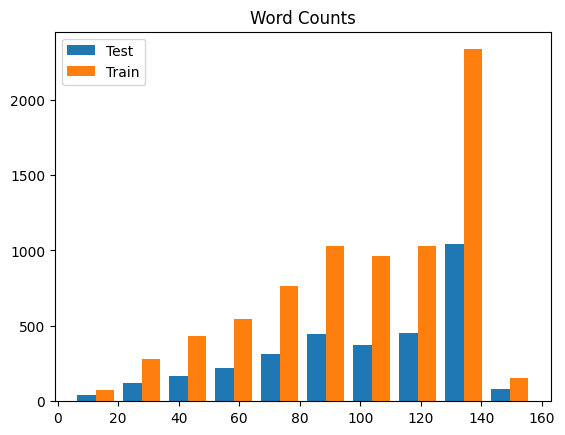

In [4]:
# Graph text length for the test and train

test_words = test_df["text"].str.split(" ")
test_word_count = test_df["text"].str.len()
train_words = train_df["text"].str.split(" ")
train_word_count = train_df["text"].str.len()

print("Test:")
print(test_word_count.describe())
print("Train:")
print(train_word_count.describe())

# Count number of unique words
print("Unique Words:")
all_words = set()
for word_list in test_words:
    for word in word_list:
        all_words.add(word.lower())
for word_list in train_words:
    for word in word_list:
        all_words.add(word.lower())
print(len(all_words))

plt.hist([test_word_count, train_word_count], label=["Test", "Train"])
plt.title("Word Counts")
plt.legend()
plt.show()

# Model Architecture

From the info the max words is 157 between the training and test samples, will need to use the Keras tokenizer and padding to make sure all of the input are the same length and are numerical. Keras tokenize and padding seems simple and straight forward so that is what I will use. Also it looks like there are about 36826 words which will be used to tune the Embedding layer and tokenizer.

Also, planning to use an Embedding layer to start to lower the complexity of the input data before feeding it into an LSTM layer to keep track of previous words used and then feeed that to a Dense layer for output. From that the xomplexity will be added.


In [5]:
tokenizer = Tokenizer(num_words=36000)
tokenizer.fit_on_texts(all_words)

train_padded_word_sequences = pad_sequences(tokenizer.texts_to_sequences(train_df["text"]), maxlen=157)
test_padded_word_sequences = pad_sequences(tokenizer.texts_to_sequences(test_df["text"]), maxlen=157)

train_labels = np.array(train_df["target"])


In [6]:


model = Sequential([
    Embedding(36000, 256),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(),
        FalseNegatives(),
    ],
)


with tf.device("/device:GPU:0"):
    model_fit = model.fit(
        x=train_padded_word_sequences,
        y=train_labels,
        batch_size=None,
        epochs=20,
        verbose="auto",
        validation_split=0.2,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
    )


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - binary_accuracy: 0.6000 - false_negatives: 1009.5625 - loss: 0.6715 - val_binary_accuracy: 0.6907 - val_false_negatives: 319.0000 - val_loss: 0.6198
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.7233 - false_negatives: 518.5781 - loss: 0.5644 - val_binary_accuracy: 0.7820 - val_false_negatives: 265.0000 - val_loss: 0.4909
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.8591 - false_negatives: 308.4010 - loss: 0.3526 - val_binary_accuracy: 0.7971 - val_false_negatives: 193.0000 - val_loss: 0.4476
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9030 - false_negatives: 218.0521 - loss: 0.2512 - val_binary_accuracy: 0.7951 - val_false_negatives: 197.0000 - val_loss: 0.4606
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9396 - false_negatives: 143.7292 - loss: 0.1687 - val_binary_accuracy: 0.7932 - val_false_negatives: 200.000

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 157, 256)       │     9,216,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,239,749 (107.73 MB)

 Trainable params: 9,413,249 (35.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,826,500 (71.82 MB)

None


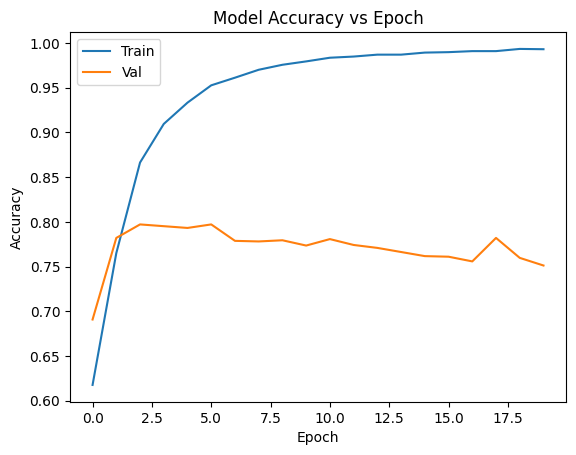

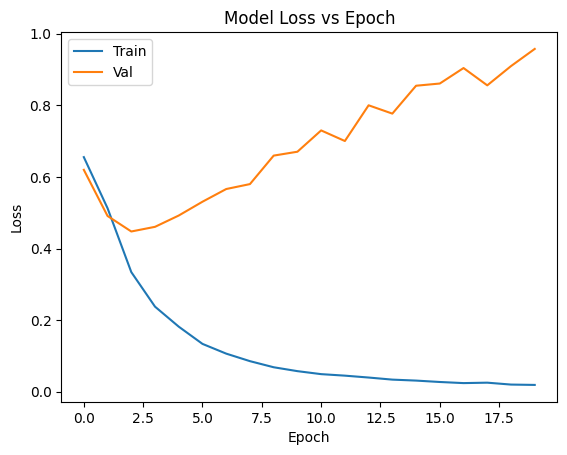

In [8]:
print(model.summary())

# Graphs for the previous model fit
# Accuracy
plt.plot(model_fit.history["binary_accuracy"])
plt.plot(model_fit.history["val_binary_accuracy"])
plt.title("Model Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Loss
plt.plot(model_fit.history["loss"])
plt.plot(model_fit.history["val_loss"])
plt.title("Model Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Results and analysis

Looks like after about epoch two it over fits, so lowering the number of epochs to two. Also will need to compare it to GRU layer and see if it works better in this situation.

In [10]:
model = Sequential([
    Embedding(36000, 256),
    GRU(128),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(),
        FalseNegatives(),
    ],
)


with tf.device("/device:GPU:0"):
    model_fit = model.fit(
        x=train_padded_word_sequences,
        y=train_labels,
        batch_size=None,
        epochs=20,
        verbose="auto",
        validation_split=0.2,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
    )

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - binary_accuracy: 0.5696 - false_negatives_1: 1186.3750 - loss: 0.6817 - val_binary_accuracy: 0.6776 - val_false_negatives_1: 312.0000 - val_loss: 0.6237
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.6854 - false_negatives_1: 550.7552 - loss: 0.5960 - val_binary_accuracy: 0.7203 - val_false_negatives_1: 130.0000 - val_loss: 0.5598
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.8425 - false_negatives_1: 322.8594 - loss: 0.3916 - val_binary_accuracy: 0.7899 - val_false_negatives_1: 160.0000 - val_loss: 0.4514
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9062 - false_negatives_1: 187.5208 - loss: 0.2470 - val_binary_accuracy: 0.8024 - val_false_negatives_1: 210.0000 - val_loss: 0.4597
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9480 - false_negatives_1: 114.8906 - loss: 0.1518 - val_binary_accuracy: 0.7853 - val_false_negat

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 157, 256)       │     9,216,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,093,061 (107.17 MB)

 Trainable params: 9,364,353 (35.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,728,708 (71.44 MB)

None


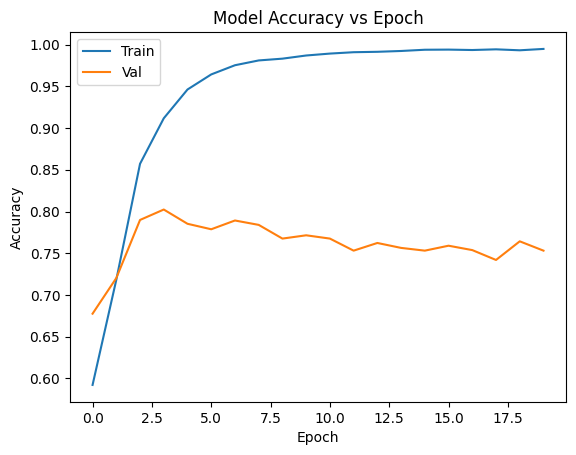

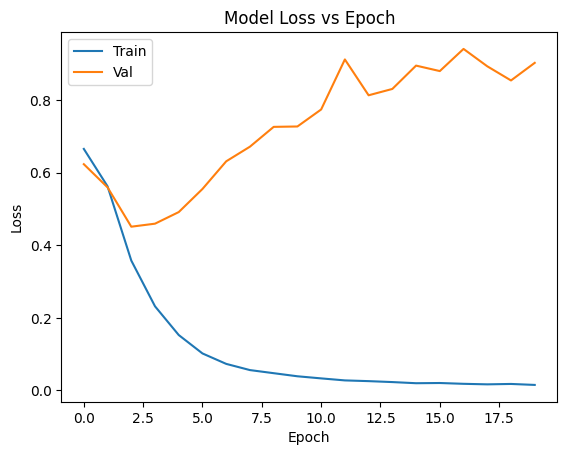

In [11]:
print(model.summary())

# Graphs for the previous model fit
# Accuracy
plt.plot(model_fit.history["binary_accuracy"])
plt.plot(model_fit.history["val_binary_accuracy"])
plt.title("Model Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Loss
plt.plot(model_fit.history["loss"])
plt.plot(model_fit.history["val_loss"])
plt.title("Model Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

From those two models comparing between GRU and LTSM, I am going to move forward with the GRU since it had fewer false negatives and better accuracy at about epoch three.

In [12]:
# Training submission model with three epochs

model = Sequential([
    Embedding(36000, 256),
    GRU(128),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(),
        FalseNegatives(),
    ],
)


with tf.device("/device:GPU:0"):
    model_fit = model.fit(
        x=train_padded_word_sequences,
        y=train_labels,
        batch_size=None,
        epochs=3,
        verbose="auto",
        validation_split=0.2,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
    )

Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - binary_accuracy: 0.5642 - false_negatives_2: 1201.6094 - loss: 0.6810 - val_binary_accuracy: 0.6579 - val_false_negatives_2: 405.0000 - val_loss: 0.6297
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.7006 - false_negatives_2: 572.6927 - loss: 0.5912 - val_binary_accuracy: 0.7597 - val_false_negatives_2: 232.0000 - val_loss: 0.5236
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.8503 - false_negatives_2: 299.5417 - loss: 0.3770 - val_binary_accuracy: 0.7951 - val_false_negatives_2: 209.0000 - val_loss: 0.4488


In [18]:
submission_file = Path("submission.csv")

predictions = model.predict(train_padded_word_sequences)

# Delete exsiting submission file
submission_file.unlink(missing_ok=True)

with submission_file.open("a") as f:
    f.write("id,target\n")
    for test_id, prediction in zip(test_df["id"], predictions):
        f.write(f"{test_id},{int(np.round(prediction[0]))}\n")

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# Conclusion

It is amazing the amount of accuracy that can be accomplished with a relatively simple model. Also the build in Keras ability to simplify text processing will be used by my again in the future. Changing between LSTM and GRU gave only a marginal benefit, but favoring speed of the model made me hesitant to change the model to something more complicated with minimal gain.

### References

https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_TFCO_Wiki_Case_Study

